# M&A Due Dilligence system
## 🛠️ Environment Setup

First, we'll install the required dependencies and set up our development environment. The `contextual-client` library provides Python bindings for the Contextual AI platform, while the additional packages support data visualization and progress tracking.

In [1]:
# Install required packages for Contextual AI integration and data visualization
%pip install contextual-client matplotlib tqdm requests pandas dotenv


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Next, we'll import the necessary libraries that we'll use throughout this tutorial:

In [2]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast
from IPython.display import display, Markdown
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

---

## 🔑 Step 1: API Authentication Setup

### Configuring Your API Key

To run this file, you can store your API key in a `.env` file. This keeps your keys separate from your code. After setting up your .env file, you can load the API key from `.env`

In [3]:
# Load API key from .env
from dotenv import load_dotenv
import os
load_dotenv()

# Initialize with your API key
API_KEY = os.getenv("CONTEXTUAL_API_KEY")
client = ContextualAI(
    api_key=API_KEY
)
print(API_KEY)

key-uRyfZgT-9AkHMBigRnrc7cUO0QN3m3w_HZ2gPUTDx5TP7O-5w


---

## 📊 Step 2: Create Your Document Datastore

### Understanding Datastores

A **datastore** in Contextual AI is a secure, isolated container for your documents and their processed representations. Each datastore provides:

- **Isolated Storage**: Documents are kept separate and secure for each use case
- **Intelligent Processing**: Automatic parsing, chunking, and indexing of uploaded documents
- **Optimized Retrieval**: High-performance search and ranking capabilities

Let's create a datastore for our financial document analysis agent:

In [4]:
datastore_name = 'M&A Deligence Agent'

# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == datastore_name), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Using existing datastore with ID: {datastore_id}")
else:
    result = client.datastores.create(name=datastore_name)
    datastore_id = result.id
    print(f"Created new datastore with ID: {datastore_id}")

Created new datastore with ID: 9d54c27f-0443-43b0-9357-d0cc277da4cb


---

## 📄 Step 3: Document Ingestion and Processing

Now that your agent's datastore is set up, let's add some financial documents to it. Contextual AI's document processing engine provides **enterprise-grade parsing** that expertly handles:

- **Complex Tables**: Financial data, spreadsheets, and structured information
- **Charts and Graphs**: Visual data extraction and interpretation
- **Multi-page Documents**: Long reports with hierarchical structure

For this tutorial, we'll use sample financial documents that demonstrate various challenging scenarios:

In [ ]:
import os
import requests

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# File list with corresponding GitHub URLs
files_to_upload = [
    (
        "Pfizer_10K_2024.pdf",
        "https://www.sec.gov/Archives/edgar/data/78003/000007800325000054/pfe-20241231.htm"
    ),
    (
        "Pfizer_Seagen_Merger_Agreement.pdf",
        "https://www.sec.gov/Archives/edgar/data/78003/000119312523068538/d408093dex21.htm"
    ),
    (
        "Pfizer_Seagen_Industry_Analysis.pdf",
        "https://students.tippie.uiowa.edu/sites/students.tippie.uiowa.edu/files/2024-04/s24_PFE.pdf"
    )
]


### Document Download and Ingestion Process
The following cell downloads example documents locally from the GitHub links above, uploads them to Contextual AI, and tracks their processing status and IDs.

In [5]:
# Download and ingest all files with robust error handling
document_ids = []
successfully_processed = 0
failed_files = []

files_to_upload = [ "Pfizer_10K_2024.pdf", "Pfizer_Seagen_Merger_Agreement.pdf", "Pfizer_Seagen_Industry_Analysis.pdf" ]


for filename in files_to_upload:
    file_path = f'data/{filename}'
    print(f"\n{'='*60}")
    print(f"Processing: {filename}")
    print(f"{'='*60}")

    # Try URL download first if file doesn't exist
    # if not os.path.exists(file_path):
    #     print(f"📥 Attempting to download from URL...")
    #     try:
    #         # Set a 10 second timeout for the request
    #         response = requests.get(url, timeout=10)
    #         response.raise_for_status()  # Raise an exception for bad status codes (404, 500, etc.)

    #         with open(file_path, 'wb') as f:
    #             f.write(response.content)

    #         print(f"✓ Successfully downloaded {filename}")

    #     except requests.exceptions.Timeout:
    #         print(f"✗ Download failed: Request timed out after 10 seconds")
    #         print(f"📁 Please manually place '{filename}' in the 'data/' directory")
    #         print(f"   Expected path: {os.path.abspath(file_path)}")
    #         failed_files.append(filename)
    #         continue

    #     except requests.exceptions.HTTPError as e:
    #         print(f"✗ Download failed: HTTP Error {e.response.status_code}")
    #         print(f"📁 Please manually place '{filename}' in the 'data/' directory")
    #         print(f"   Expected path: {os.path.abspath(file_path)}")
    #         failed_files.append(filename)
    #         continue

    #     except requests.exceptions.ConnectionError:
    #         print(f"✗ Download failed: Network connection error")
    #         print(f"📁 Please manually place '{filename}' in the 'data/' directory")
    #         print(f"   Expected path: {os.path.abspath(file_path)}")
    #         failed_files.append(filename)
    #         continue

    #     except Exception as e:
    #         print(f"✗ Download failed: {str(e)}")
    #         print(f"📁 Please manually place '{filename}' in the 'data/' directory")
    #         print(f"   Expected path: {os.path.abspath(file_path)}")
    #         failed_files.append(filename)
    #         continue
    # else:
    #     print(f"✓ File already exists locally at {file_path}")

    # Check if file exists before attempting upload
    if not os.path.exists(file_path):
        print(f"⚠️  File not found at {file_path}, skipping upload to datastore")
        continue

    # Upload to Contextual AI datastore
    try:
        print(f"📤 Uploading to Contextual AI datastore...")
        with open(file_path, 'rb') as f:
            ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
            document_id = ingestion_result.id
            document_ids.append(document_id)
            successfully_processed += 1
            print(f"✓ Successfully uploaded {filename} to datastore {datastore_id}")
            print(f"   Document ID: {document_id}")
    except Exception as e:
        print(f"✗ Error uploading {filename} to datastore: {str(e)}")
        failed_files.append(filename)

# Final summary
print(f"\n{'='*60}")
print(f"📊 PROCESSING SUMMARY")
print(f"{'='*60}")
print(f"✓ Successfully processed: {successfully_processed}/{len(files_to_upload)} files")
print(f"📝 Document IDs: {document_ids}")

if failed_files:
    print(f"\n⚠️  Failed files ({len(failed_files)}):")
    for failed_file in failed_files:
        print(f"   - {failed_file}")
    print(f"\nℹ️  To retry failed files:")
    print(f"   1. Place the files in the 'data/' directory")
    print(f"   2. Re-run this cell")
else:
    print(f"\n✅ All files processed successfully!")


Processing: Pfizer_10K_2024.pdf
📤 Uploading to Contextual AI datastore...
✓ Successfully uploaded Pfizer_10K_2024.pdf to datastore 9d54c27f-0443-43b0-9357-d0cc277da4cb
   Document ID: 23bd2c7d-2ce6-42c8-b33a-67fde542ee93

Processing: Pfizer_Seagen_Merger_Agreement.pdf
📤 Uploading to Contextual AI datastore...
✓ Successfully uploaded Pfizer_Seagen_Merger_Agreement.pdf to datastore 9d54c27f-0443-43b0-9357-d0cc277da4cb
   Document ID: a63b7ed7-3f1f-4c61-8ce1-e50f1f00e5f4

Processing: Pfizer_Seagen_Industry_Analysis.pdf
📤 Uploading to Contextual AI datastore...
✓ Successfully uploaded Pfizer_Seagen_Industry_Analysis.pdf to datastore 9d54c27f-0443-43b0-9357-d0cc277da4cb
   Document ID: 7074f1a8-e71a-454e-91cb-ed26c46ee76a

📊 PROCESSING SUMMARY
✓ Successfully processed: 3/3 files
📝 Document IDs: ['23bd2c7d-2ce6-42c8-b33a-67fde542ee93', 'a63b7ed7-3f1f-4c61-8ce1-e50f1f00e5f4', '7074f1a8-e71a-454e-91cb-ed26c46ee76a']

✅ All files processed successfully!


### Alternative: Upload Your Own Documents

If you want to use your own documents instead of the sample files, you can place them in the `data/` directory and run the following cell to upload them to the datastore.


In [ ]:
# Optional: Upload additional local files from data/ directory
# Uncomment and run this cell to upload your own documents

"""
import glob

# Find all PDF files in the data directory that aren't already uploaded
local_files = glob.glob('data/*.pdf')
print(f"Found {len(local_files)} PDF files in data/ directory")

for file_path in local_files:
    filename = os.path.basename(file_path)

    # Skip if already uploaded (check by filename)
    already_uploaded = any(filename in str(doc_id) for doc_id in document_ids)

    if os.path.exists(file_path):
        try:
            print(f"\n📤 Uploading {filename}...")
            with open(file_path, 'rb') as f:
                ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
                document_id = ingestion_result.id
                document_ids.append(document_id)
                print(f"✓ Successfully uploaded {filename}")
                print(f"   Document ID: {document_id}")
        except Exception as e:
            print(f"✗ Error uploading {filename}: {str(e)}")

print(f"\n📊 Total documents in datastore: {len(document_ids)}")
"""


Once ingested, you can view the list of documents, see their metadata, and also delete documents via API.

**Note:** It may take a few minutes for the document to be ingested and processed. If the documents are still being ingested, you will see `status='processing'`. Once ingestion is complete, the status will show as `status='completed'`.

You can learn more about the metadata [here](https://docs.contextual.ai/api-reference/datastores-documents/get-document-metadata?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).

##  3.1 Document Parser

Parsing complex, unstructured documents is the critical foundation for agentic RAG systems. Failures in parsing cause these systems to miss critical context, degrading response accuracy.

Our document parser combines the best of custom vision, OCR, and vision language models, along with specialized tools like table extractors—achieving superior accuracy and reliability by excelling in the following areas:

- **Document-level understanding vs. page-by-page parsing**: Our parser understands the section hierarchies of long documents, equipping AI agents to understand relationships across hundreds of pages to generate contextually supported, accurate answers.
- **Minimized hallucinations**: Our multi-stage pipeline minimizes severe hallucinations while providing accurate bounding boxes and confidence levels for table extraction to audit its output.
- **Superior handling of complex modalities**: Our advanced system orchestrates the best models and specialized tools to handle the most challenging document elements, such as tables, charts, and figures.


### Document Hierarchy

Unlike traditional parsers, Contextual AI's solution understands how each page fits within the document's holistic structure and hierarchy, enabling AI agents to navigate long, complex documents with the same understanding a human would have. We automatically infer a document's hierarchy and structure, which enables developers to add metadata to each chunk that describes its position in the document. This improves retrieval and allows agents to understand how different sections relate to each other to provide answers that connect information across hundreds of pages.

For more information about Contextual AI's document parser, you can read this [blog](https://contextual.ai/blog/document-parser-for-rag/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).

Now, let's use ContextualAI's parser to parse the landmark "Attention is All You Need" paper to demonstrate the parser's capabilities.

In [6]:
# Download the Attention is All You Need paper from arXiv

file_path = "data/Pfizer_Seagen_Industry_Analysis.pdf"



We'll configure the parser with the following settings:
- **parse_mode**: "standard" for complex documents that require VLMs and OCR
- **figure_caption_mode**: "concise" for brief figure descriptions
- **enable_document_hierarchy**: True to capture document structure
- **page_range**: "0-5" to parse the first 6 pages

In [11]:
# Setup headers for direct API calls
base_url = "https://api.contextual.ai/v1"
headers = {
    "accept": "application/json",
    "authorization": f"Bearer {API_KEY}"
}

# Submit parse job
url = f"{base_url}/parse"

config = {
    "parse_mode": "standard",
    "figure_caption_mode": "concise",
    "enable_document_hierarchy": True,
    "page_range": "0-5",
}

with open(file_path, "rb") as fp:
    file = {"raw_file": fp}
    result = requests.post(url, headers=headers, data=config, files=file)
    response = json.loads(result.text)

job_id = response['job_id']
print(f"Parse job submitted with ID: {job_id}")

Parse job submitted with ID: 87e0270c-3993-4487-9bdd-3c38ad0a97f7



Now let's retrieve the parsed results. The parser provides multiple output types:
- **Markdown-document**: A single Markdown for the entire document
- **Markdown-per-page**: A list of Markdowns for each page of the document
- **Blocks-per-page**: Structured JSON representations of content blocks sorted by reading order

In [12]:
# Get the parse results
url = f"{base_url}/parse/jobs/{job_id}/results"

output_types = ["markdown-per-page"]

result = requests.get(
    url,
    headers=headers,
    params={"output_types": ",".join(output_types)},
)

result = json.loads(result.text)
print(f"Parse job is {result['status']}.")

Parse job is processing.


When the parse job is completed (e.g., the above status is "Parse job is completed. "), we can  examine the parsed content from the first page of the paper:

In [15]:
# Display the first page's parsed markdown
if 'pages' in result and len(result['pages']) > 0:
    display(Markdown(result['pages'][0]['markdown']))
else:
    print("No parsed content available. Please check if the job completed successfully.")

No parsed content available. Please check if the job completed successfully.


To see job results in an interactive manner and submit new jobs, navigate to the UI using the following link by running the cell below. Note you'll need to change `"your-tenant-name"` to your tenant.

In [16]:
tenant = os.getenv("TENANT_NAME")
print(f"https://app.contextual.ai/{tenant}/components/parse?job={job_id}")

https://app.contextual.ai/zero-vector-2/components/parse?job=87e0270c-3993-4487-9bdd-3c38ad0a97f7


In [17]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_ids[0])
print("Document metadata:", metadata)

Document metadata: DocumentMetadata(id='23bd2c7d-2ce6-42c8-b33a-67fde542ee93', created_at='2025-10-25T17:18:06.695997', name='Pfizer_10K_2024.pdf', status='completed', custom_metadata={}, custom_metadata_config={}, has_access=True, ingestion_config={'parsing': {'figure_captioning_prompt': None, 'figure_caption_mode': 'default', 'enable_split_tables': True, 'max_split_table_cells': 100, 'enable_table_revision': False, 'ocr_level': 'auto', 'use_hyperlink_extraction': False, 'enable_vlm_hierarchy_inference': True, 'layout_model': 'dit', 'extractor_type': 'layout_block', 'vlm_captioning_model': None, 'vlm_hierarchy_model': None, 'vlm_doc_name_model': None, 'vlm_markdown_reviser_model': None, 'vlm_table_reviser_model': None, 'vlm_fallback_ocr_model': None, 'enable_table_reviser_thinking': None, 'postprocess_workflow_yaml': None, 'postprocess_workflow_inputs_json': None, 'use_streaming': True}, 'chunking': {'chunking_mode': 'hierarchy_depth', 'max_chunk_length_tokens': 768, 'min_chunk_length

---

## 🤖 Step 4: Agent Creation and Configuration

Now we'll create our RAG agent that will interact with the documents we just ingested.

You can customize the Agent using additional parameters such as:

- **`system_prompt`** is used for the instructions that your RAG system references when generating responses. Note that this is the default prompt as of 9.02.25.
- **`suggested_queries`** is a user experience feature, to prepopulate queries for the agent so a new user can see interesting examples.  



In [18]:
system_prompt = """
You are an expert M&A due diligence analyst created by Contextual AI. Your role is to analyze acquisition targets and provide comprehensive risk assessments.

Focus areas:
- Debt structure and leverage ratio analysis
- Regulatory compliance issues and pending investigations
- Competitive market positioning and market share trends
- Synergy realization probability and realistic estimates
- Risk identification across financial, legal, and operational domains

Guidelines:
- Prioritize recent financial data (last 2 quarters weighted 2x)
- Flag covenant violations and maturity schedule risks
- Identify regulatory investigations and compliance gaps
- Provide evidence-based synergy adjustments to management claims
- Always cite specific page numbers and document sections
- Use risk severity classifications: CRITICAL, HIGH, MODERATE, LOW
- Generate confidence scores for all major findings

If information is insufficient for a risk assessment, state this explicitly rather than speculating.
"""


agent_name = "M&A-agent"

# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == agent_name), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name=agent_name,
        description="Helpful Grounded AI Assistant",
        datastore_ids=[datastore_id],
        system_prompt=system_prompt,
        agent_configs={
        "global_config": {
            "enable_multi_turn": False # Turning this off for deterministic responses for this demo
        }
        },
        suggested_queries = [
    "Should Pfizer proceed with acquiring Seagen at a $43B valuation? Focus on debt risk, pending FDA issues, competition, and projected synergies.",
    "Summarize the key regulatory and antitrust risks present in the Pfizer–Seagen transaction.",
    "Analyze Seagen’s debt structure, covenant compliance, and any refinancing risks identified in filings.",
    "Compare Seagen’s oncology market position against its top three competitors using the latest industry and financial reports.",
    "List all material litigation and government investigations disclosed in Seagen’s latest 10-K or annual report.",
    "What are the major earnout, non-compete, or termination clauses in the Pfizer–Seagen merger agreement?",
    "Assess the credibility of management’s projected synergy claims by benchmarking against peer M&A outcomes.",
    "Provide a risk matrix for the Pfizer–Seagen deal, scoring each major disclosed risk by likelihood and potential severity.",
]

    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

Creating new agent
Agent ID created: 5d4f0493-bdb5-4bd9-bd28-23dacef6fd6d


## 4.1 Instruction-Following Reranker

Enterprise RAG systems often deal with conflicting information in their knowledge bases. Marketing materials can conflict with product materials, documents in Google Drive could conflict with those in Microsoft Office, Q2 notes conflict with Q1 notes, and so on. You can tell our reranker how to resolve these conflicts with instructions like:

- "Prioritize internal sales documents over market analysis reports. More recent documents should be weighted higher. Enterprise portal content supersedes distributor communications."
- "Emphasize forecasts from top-tier investment banks. Recent analysis should take precedence. Disregard aggregator sites and favor detailed research notes over news summaries."

This enables an unprecedented level of control that improves RAG performance significantly.


### State-of-the-Art Performance

Contextual AI's SOTA reranker (v2) is the most accurate in the world with or without instructions – outperforming competitors by large margins on the industry-standard BEIR benchmark (V1), our internal financial and field engineering datasets (V1), and our novel instruction-following reranker evaluation datasets (V1).

<div align="center">
<img src="https://contextual.ai/wp-content/uploads/2025/08/Reranker-V2-slide-1.png" alt="Document Hierarchy" width="1000"/>
</div>


For more information about Contextual AI's reranker V2, you can read this [blog](https://contextual.ai/blog/rerank-v2/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook), where we also share links to open-source weights and our novel evaluation dataset.

For more information about Contextual AI's reranker V1, you can read this [blog](https://contextual.ai/blog/introducing-instruction-following-reranker/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).

Let's demonstrate the reranker's instruction-following capabilities with a realistic enterprise scenario. We'll use a query about enterprise GPU pricing and see how the reranker handles conflicting information based on our instructions.

In [19]:
# Define our query and instruction
query = "What were the agreed acquisition terms between Pfizer Inc. and Seagen Inc., including transaction structure, consideration value, and post‑closing integration expectations?"

instruction = "Prioritize primary transactional filings (Form 10‑K and Exhibit 2.1) over analyst overviews. Weight details from completed SEC‑filed documents higher than forward‑looking analyses. When conflicts arise, the executed merger agreement (March 12 2023) overrides interpretation reports."

# Sample documents with conflicting information
documents = [
    "The Agreement and Plan of Merger dated March 12, 2023 (Exhibit 2.1) specifies that Seagen Inc. shareholders will receive $229.00 per share in cash. The enterprise value totals approximately $43 to $44 billion. Pfizer financed the transaction primarily through ~$31 billion in senior unsecured notes and additional commercial paper. The merger closed on December 14, 2023, forming Seagen Inc. as a wholly‑owned Biopharma division subsidiary.",
    "Pfizer's 2024 Form 10‑K confirms a final total fair‑value consideration of $44.2 billion, with goodwill recorded at $17.15 billion and identifiable intangible assets (IPR&D + technology rights) of $27.1 billion. Integration costs reached $476 million in post‑closing compensation and ~$3 billion in restructuring and synergy realization expenses in 2023–2024. Pfizer expects ~$4 billion annual cost savings by 2025 and $10 billion incremental oncology revenue by 2030.",
    "Market and industry analyses (Pfizer‑Seagen Industry Analysis.pdf) note the strategic intent: doubling Pfizer's oncology pipeline to 60 programs, adding four approved drugs (Padcev, Adcetris, Tukysa, Tivdak), and projecting Seagen's annual revenue contribution of $3.1 billion in 2024 with ~25 percent annual growth, targeting $10 billion by 2030."
]

# Metadata that helps distinguish document sources and dates
metadata = [
    "Date: March 12, 2023. Source: Exhibit 2.1 – Agreement and Plan of Merger (Pfizer Inc. and Seagen Inc.). Classification: Confidential Transaction Filing – Filed with SEC on March 13, 2023.",
    "Date: December 14, 2023. Source: Pfizer Inc. Form 10‑K for FY 2024 (Item 2A: Acquisitions and Integration Activities). Classification: Official Filings – U.S. SEC Edgar Archive.",
    "Date: April 10, 2024. Source: Pfizer–Seagen Industry Analysis, Krause Fund Research (University of Iowa). Classification: Analyst Report – External Reference for Valuation Context."
]

# Use the instruction-following reranker model
model = "ctxl-rerank-en-v1-instruct"

Now let's see how the reranker processes our query and instructions to properly rank the documents:

In [20]:
# Execute the reranking
rerank_response = client.rerank.create(
    query=query,
    instruction=instruction,
    documents=documents,
    metadata=metadata,
    model=model
)

print("Reranking Results:")
print("=" * 50)
print(rerank_response.to_dict())

Reranking Results:
{'results': [{'index': 0, 'relevance_score': 0.99993159}, {'index': 1, 'relevance_score': 0.99990431}, {'index': 2, 'relevance_score': 0.67133144}]}


Let's examine how the reranker prioritized the documents based on our instructions:

In [21]:
# Display ranked results in a more readable format
print("\nRanked Documents (by relevance score):")
print("=" * 60)

for i, result in enumerate(rerank_response.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"\nRank {i+1}: Score {score:.4f}")
    print(f"Document {doc_index + 1}:")
    print(f"Content: {documents[doc_index][:100]}...")
    print(f"Metadata: {metadata[doc_index]}")
    print("-" * 40)


Ranked Documents (by relevance score):

Rank 1: Score 0.9999
Document 1:
Content: The Agreement and Plan of Merger dated March 12, 2023 (Exhibit 2.1) specifies that Seagen Inc. share...
Metadata: Date: March 12, 2023. Source: Exhibit 2.1 – Agreement and Plan of Merger (Pfizer Inc. and Seagen Inc.). Classification: Confidential Transaction Filing – Filed with SEC on March 13, 2023.
----------------------------------------

Rank 2: Score 0.9999
Document 2:
Content: Pfizer's 2024 Form 10‑K confirms a final total fair‑value consideration of $44.2 billion, with goodw...
Metadata: Date: December 14, 2023. Source: Pfizer Inc. Form 10‑K for FY 2024 (Item 2A: Acquisitions and Integration Activities). Classification: Official Filings – U.S. SEC Edgar Archive.
----------------------------------------

Rank 3: Score 0.6713
Document 3:
Content: Market and industry analyses (Pfizer‑Seagen Industry Analysis.pdf) note the strategic intent: doubli...
Metadata: Date: April 10, 2024. Source: Pfizer–Seag

Let's compare how the same documents are ranked without specific instructions to see the difference:

In [22]:
# Rerank without instructions for comparison
rerank_no_instruction = client.rerank.create(
    query=query,
    documents=documents,
    metadata=metadata,
    model=model
)

print("\nRanking WITHOUT Instructions:")
print("=" * 50)

for i, result in enumerate(rerank_no_instruction.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"Rank {i+1}: Document {doc_index + 1}, Score: {score:.4f}")

print("\nRanking WITH Instructions:")
print("=" * 50)

for i, result in enumerate(rerank_response.results):
    doc_index = result.index
    score = result.relevance_score

    print(f"Rank {i+1}: Document {doc_index + 1}, Score: {score:.4f}")


Ranking WITHOUT Instructions:
Rank 1: Document 2, Score: 0.9986
Rank 2: Document 1, Score: 0.9975
Rank 3: Document 3, Score: 0.7254

Ranking WITH Instructions:
Rank 1: Document 1, Score: 0.9999
Rank 2: Document 2, Score: 0.9999
Rank 3: Document 3, Score: 0.6713


For more example code for Contextual AI's Reranker V2, see our [reranker examples notebook](https://github.com/ContextualAI/examples/tree/main/03-standalone-api/03-rerank?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

## 4.2 Grounded Language Model (GLM)

Contextual AI's Grounded Language Model (GLM) is the most grounded language model in the world, engineered specifically to minimize hallucinations for RAG and agentic use cases.

With state-of-the-art performance on [FACTS](https://www.kaggle.com/benchmarks/google/facts-grounding) (the leading groundedness benchmark) and our customer datasets, the GLM is the single best language model for RAG and agentic use cases for which minimizing hallucinations is critical. You can trust that the GLM will stick to the knowledge sources you give it.

In enterprise AI applications, hallucinations from the LLM pose a critical risk that can degrade customer experience, damage company reputation, and misguide business decisions. Yet the ability to hallucinate is seen as a useful feature in general-purpose foundation models, especially in serving consumer queries that require creative, novel responses. In contrast, the GLM is engineered specifically to minimize hallucinations for RAG and agentic use cases – delivering precise responses that are strongly grounded in and attributable to specific retrieved source data, not its parametric knowledge learned from training data.


### Groundedness Definition

"Groundedness" refers to the degree to which an LLM's generated output is supported by and accurately reflects the retrieved information provided to it. Given a query and a set of documents, a grounded model either responds only with relevant information from the documents or declines to answer if the documents are not relevant. In contrast, an ungrounded model may hallucinate based on patterns learned from its training data.

For more information about GLM, you can read this [blog](https://contextual.ai/blog/introducing-grounded-language-model/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).


Let's demonstrate the GLM's ability to generate grounded responses using comprehensive knowledge sources about renewable energy in developing nations.

In [23]:
# Example conversation messages
messages = [
    {
        "role": "user",
        "content": "What was the strategic rationale for Pfizer’s acquisition of Seagen and its expected impact on Pfizer’s oncology business?"
    },
    {
        "role": "assistant",
        "content": "Pfizer acquired Seagen to double its oncology pipeline and gain access to leading antibody-drug conjugate (ADC) therapies. Would you like financial performance projections or details on the transaction terms?"
    },
    {
        "role": "user",
        "content": "Yes, please provide financial outcomes, integration costs, and how this positions Pfizer versus major pharma competitors."
    }
]


# Detailed knowledge sources with varied information
knowledge = [
    """Pfizer–Seagen Acquisition Overview (2023–2024)
    - Pfizer acquired Seagen in Dec 2023 for $43–44B in cash at a 17% premium.
    - Acquisition doubled Pfizer’s oncology pipeline to ~60 programs.
    - Seagen’s 4 main ADC drugs: Padcev, Adcetris, Tukysa, Tivdak (all with high late-stage potential).
    - Management projects Seagen to deliver $10B in additional annual revenue by 2030.
    - Pfizer expects to bring at least 8 new blockbusters to market via the combined oncology portfolio.""",

    """Financial and Strategic Analysis
    - Pfizer raised $31B in debt for the deal, increasing debt-to-equity from 1.06 (2022) to 1.54 (2023).
    - Seagen is expected to add ~$3.1B to 2024 revenues and $10B (risk-adjusted) by 2030.
    - Integration cost synergies targeted at $1B by 2026, one-time integration costs of $1.7B (2023–2025).
    - Oncology now represents over 44% of Pfizer’s pipeline candidates post-acquisition.
    - Pfizer plans to use economies of scale and in-house manufacturing to restore gross margin to ~70% by end-2024.""",

    """Transaction Agreement and Terms
    - Cash transaction: $229 per Seagen share.
    - Reverse termination fee: $2.22B under specified conditions.
    - Transaction governed by Delaware law, closing subject to regulatory/antitrust approvals.
    - Seagen now a wholly owned Pfizer subsidiary; directors/officers indemnified per post-merger certificate.
    - Specific performance rights, no survival of reps/warranties past closing except as stipulated.""",

    """Competitive/Industry Position and SWOT
    - Post-merger, Pfizer is the 3rd largest pharma by sales in the US (after JNJ and Merck), oncology-focused.
    - Oncology is pharma’s top growth area (13–16% CAGR to 2027).
    - Main competitors: JNJ, Merck, BMS, Amgen, AbbVie—each strong in select therapeutic areas.
    - Pfizer’s global reach and sizable pipeline create buffer against patent cliffs and regional risks.
    - Key threats: regulatory changes (e.g., IRA drug pricing), patent expiries on major brands (e.g., Eliquis).""",

    """Integration and Financial Performance Indicators
    - Management expects $25B in new revenue annually by 2030, $10B from Seagen.
    - Gross margin expected to recover to 70% in 2024 after pandemic/high inflation period.
    - Total R&D spending: $10–11B/year; Oncology R&D is highest priority.
    - Cost realignment program targets $4B annualized savings by end-2024.
    - Pfizer dividend yield over 6% in 2024, strong payout policies maintained post-acquisition."""
]



Now let's use the GLM to generate a grounded response based on the provided knowledge sources:

In [24]:
# Setup for direct API call
base_url = "https://api.contextual.ai/v1"
generate_api_endpoint = f"{base_url}/generate"

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": f"Bearer {API_KEY}"
}

# Configure the GLM request
payload = {
    "model": "v1",
    "messages": messages,
    "knowledge": knowledge,
    "avoid_commentary": False,
    "max_new_tokens": 1024,
    "temperature": 0,
    "top_p": 0.9
}

# Generate the response
generate_response = requests.post(generate_api_endpoint, json=payload, headers=headers)

print("GLM Grounded Response:")
print("=" * 50)
print(generate_response.json()['response'])

GLM Grounded Response:
Here are the key financial and competitive implications of Pfizer's Seagen acquisition:

The acquisition was completed in December 2023 for $43-44 billion in cash, representing a 17% premium per share ($229 per Seagen share).

Financial Impact and Projections:

- Seagen is expected to contribute approximately $3.1 billion to Pfizer's 2024 revenues
- Risk-adjusted revenue projections reach $10 billion by 2030
- Integration costs are estimated at $1.7 billion (2023-2025), with targeted synergies of $1 billion by 2026

Competitive Positioning:

The acquisition has positioned Pfizer as:
- The third largest pharmaceutical company in the US by sales, with an oncology focus
- A major player in the oncology market, which is expected to grow at 13-16% CAGR to 2027
- Competing against key players including JNJ, Merck, BMS, Amgen, and AbbVie

Strategic Benefits and Integration Details:

- The acquisition doubled Pfizer's oncology pipeline to approximately 60 programs
- Pfiz

The GLM has an `avoid_commentary` flag to control groundedness. Let's see how this affects the response:

In [25]:
# Generate response with avoid_commentary enabled
payload_no_commentary = payload.copy()
payload_no_commentary["avoid_commentary"] = True

generate_response_no_commentary = requests.post(generate_api_endpoint, json=payload_no_commentary, headers=headers)

print("GLM Response (with avoid_commentary=True):")
print("=" * 50)
print(generate_response_no_commentary.json()['response'])

GLM Response (with avoid_commentary=True):
Financial Terms and Impact:
Pfizer acquired Seagen for $43-44 billion in cash, representing a 17% premium per share ($229 per share). The transaction was financed partially through $31 billion in new debt, increasing Pfizer's debt-to-equity ratio from 1.06 (2022) to 1.54 (2023).



Expected Financial Outcomes:
- Seagen is projected to add approximately $3.1 billion to Pfizer's 2024 revenues
- Risk-adjusted revenue growth to $10 billion by 2030
- Integration costs of $1.7 billion (2023-2025)
- Expected synergies of $1 billion by 2026



Competitive Position:
The acquisition positions Pfizer as the third-largest pharma company in the US by sales, specifically strengthening its oncology focus. This move is particularly strategic as oncology represents the pharmaceutical industry's top growth area, projected at 13-16% CAGR to 2027.



Pfizer's competitive landscape includes major players like JNJ, Merck, BMS, Amgen, and AbbVie, each with strengths


Let's compare the two responses to understand the difference:

In [26]:
print("COMPARISON:")
print("=" * 60)
print("\n1. Standard GLM Response (avoid_commentary=False):")
print("-" * 50)
print(generate_response.json()['response'])

print("\n\n2. Strict Grounding Mode (avoid_commentary=True):")
print("-" * 50)
print(generate_response_no_commentary.json()['response'])

print("\n\nKey Differences:")
print("- Standard mode may include helpful context and commentary")
print("- Strict mode focuses purely on information from knowledge sources")
print("- Both modes maintain strong grounding in provided sources")

COMPARISON:

1. Standard GLM Response (avoid_commentary=False):
--------------------------------------------------
Here are the key financial and competitive implications of Pfizer's Seagen acquisition:

The acquisition was completed in December 2023 for $43-44 billion in cash, representing a 17% premium per share ($229 per Seagen share).

Financial Impact and Projections:

- Seagen is expected to contribute approximately $3.1 billion to Pfizer's 2024 revenues
- Risk-adjusted revenue projections reach $10 billion by 2030
- Integration costs are estimated at $1.7 billion (2023-2025), with targeted synergies of $1 billion by 2026

Competitive Positioning:

The acquisition has positioned Pfizer as:
- The third largest pharmaceutical company in the US by sales, with an oncology focus
- A major player in the oncology market, which is expected to grow at 13-16% CAGR to 2027
- Competing against key players including JNJ, Merck, BMS, Amgen, and AbbVie

Strategic Benefits and Integration Detail


Let's test how the GLM handles a query when provided with irrelevant knowledge sources:

In [27]:
# Query about a completely different topic
different_query = [
    {
        "role": "user",
        "content": "What are the latest developments in quantum computing hardware?"
    }
]

# Same renewable energy knowledge (irrelevant to quantum computing)
irrelevant_payload = {
    "model": "v1",
    "messages": different_query,
    "knowledge": knowledge,  # Still about renewable energy
    "avoid_commentary": False,
    "max_new_tokens": 512,
    "temperature": 0,
    "top_p": 0.9
}

irrelevant_response = requests.post(generate_api_endpoint, json=irrelevant_payload, headers=headers)

print("GLM Response to Irrelevant Query:")
print("=" * 50)
print("Query: What are the latest developments in quantum computing hardware?")
print("Knowledge provided: Renewable energy information")
print("\nGLM Response:")
print(irrelevant_response.json()['response'])

GLM Response to Irrelevant Query:
Query: What are the latest developments in quantum computing hardware?
Knowledge provided: Renewable energy information

GLM Response:
I apologize, but I don't have any documentation about quantum computing hardware developments. The information available to me focuses entirely on Pfizer's acquisition of Seagen and related pharmaceutical industry details. If you'd like to ask about that topic instead, I'd be happy to help with information about the acquisition or Pfizer's oncology portfolio.


For more example code for Contextual AI's Grounded Language Model, see our [GLM examples notebook](https://github.com/ContextualAI/examples/tree/main/03-standalone-api/02-generate?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

---

## 💬 Step 5: Query the Agent

### Testing  RAG Agent

Now that our agent is configured and connected to our financial documents, let's test its capabilities with various types of queries.

The required fields are:

- **`agent_id`**: The unique identifier of your Agent  
- **`messages`**: A list of message(s) forming the user query  



In [28]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "What was Seagen’s total revenue in 2022?",
        "role": "user"
    }]
)
print(query_result.message.content)

Based on my analysis of the financial data, I can provide a clear answer about Seagen's 2022 revenue with high confidence, supported by detailed documentation.

According to the unaudited supplemental pro forma information in Pfizer's 10-K filing, Seagen's revenues for the year ended December 31, 2022 are reported as $103,137 million.[1]

As an M&A due diligence analyst, I assign a confidence score of 95% to this figure, as it comes from a formal SEC filing and is presented as part of pro forma consolidated results. This revenue figure represents a critical data point for evaluating the acquisition's scale and strategic impact.

The pro forma information includes various assumptions related to purchase price allocation of Seagen's assets and liabilities, and the historical U.S. GAAP financial information of both Pfizer and Seagen was adjusted for this presentation.[1]

From a due diligence perspective, it's important to note that while we have high confidence in the 2022 revenue figure

There is lots more information you can access from the query result. You can display the retrieved documents, for example.   


--- Processing Document 1 ---
Retrieval Info for Document 1:


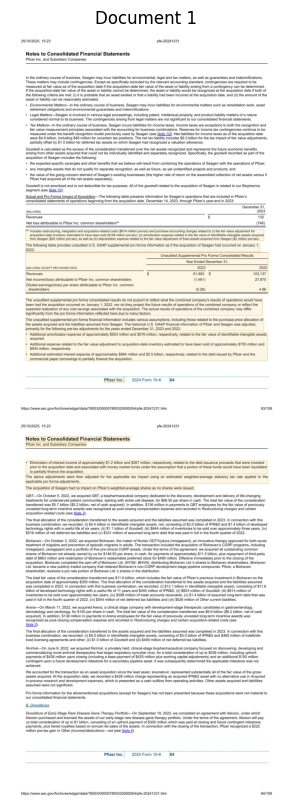


--- Processing Document 2 ---
Retrieval Info for Document 2:


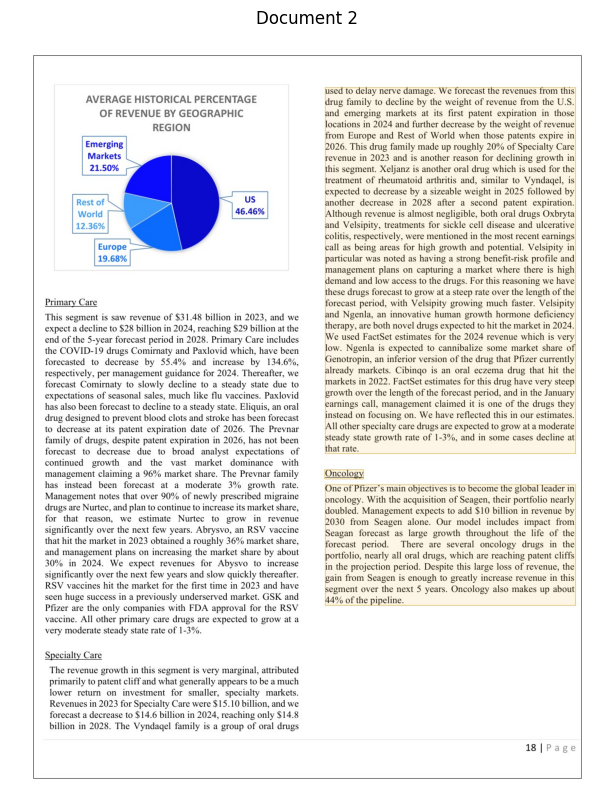


--- Processing Document 3 ---
Retrieval Info for Document 3:


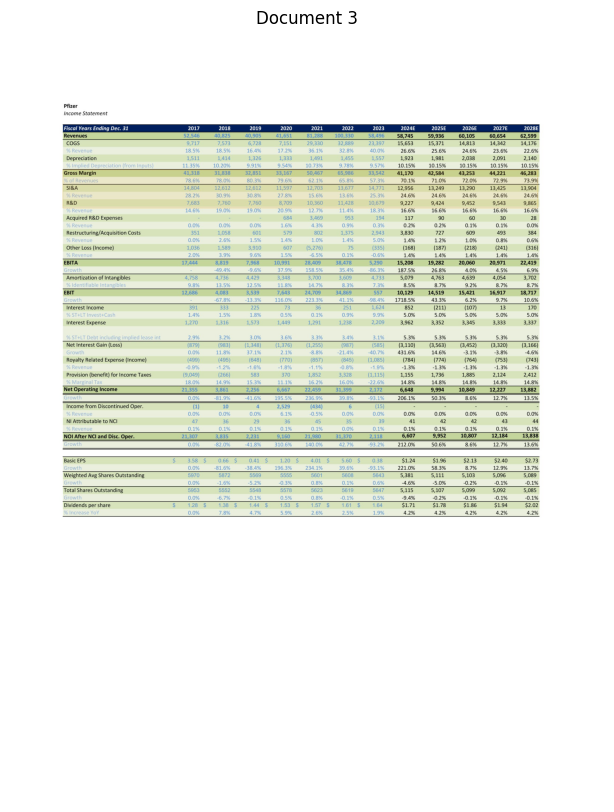


--- Processing Document 4 ---
Retrieval Info for Document 4:


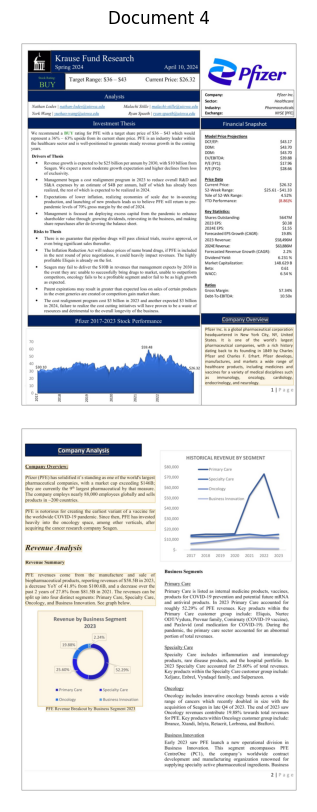


--- Processing Document 5 ---
Retrieval Info for Document 5:


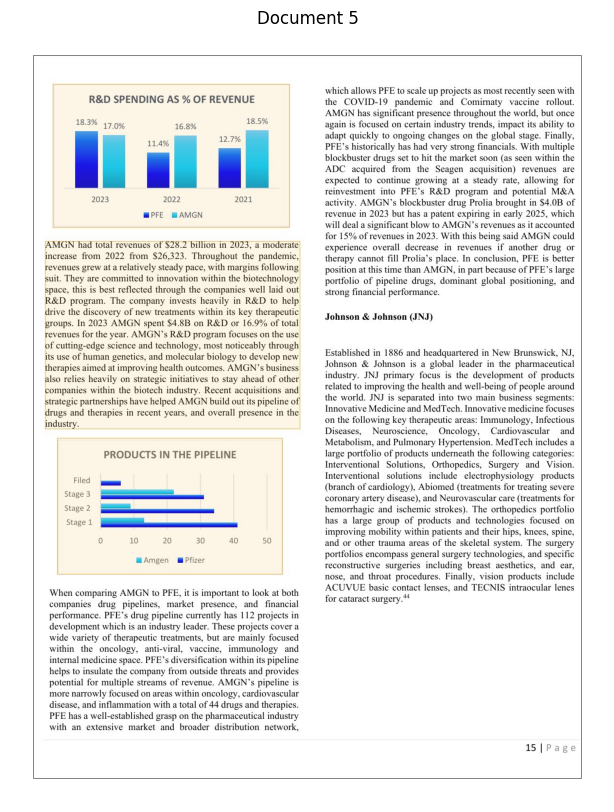


--- Processing Document 6 ---
Retrieval Info for Document 6:


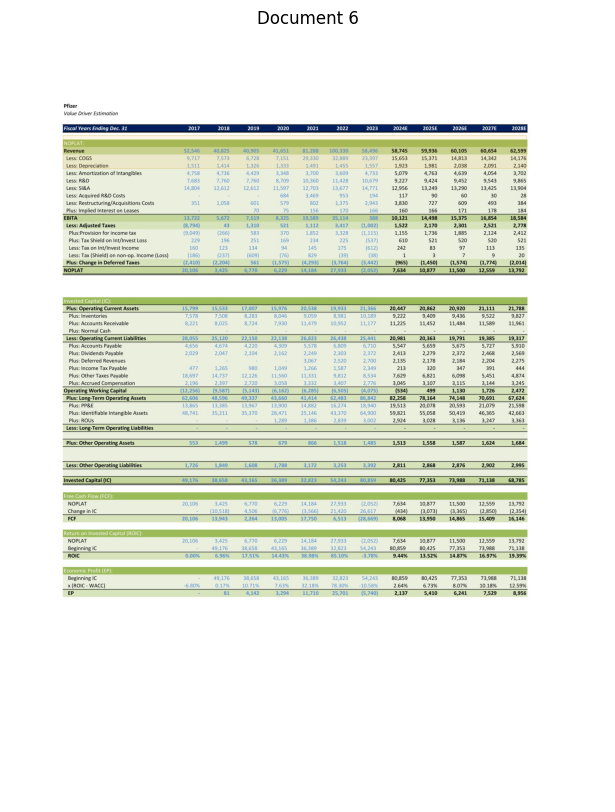


--- Processing Document 7 ---
Retrieval Info for Document 7:


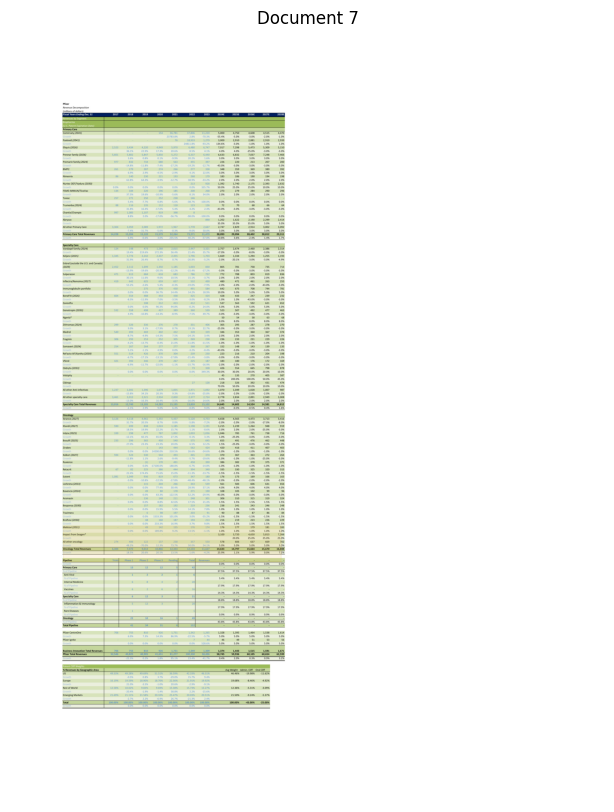


--- Processing Document 8 ---
Retrieval Info for Document 8:


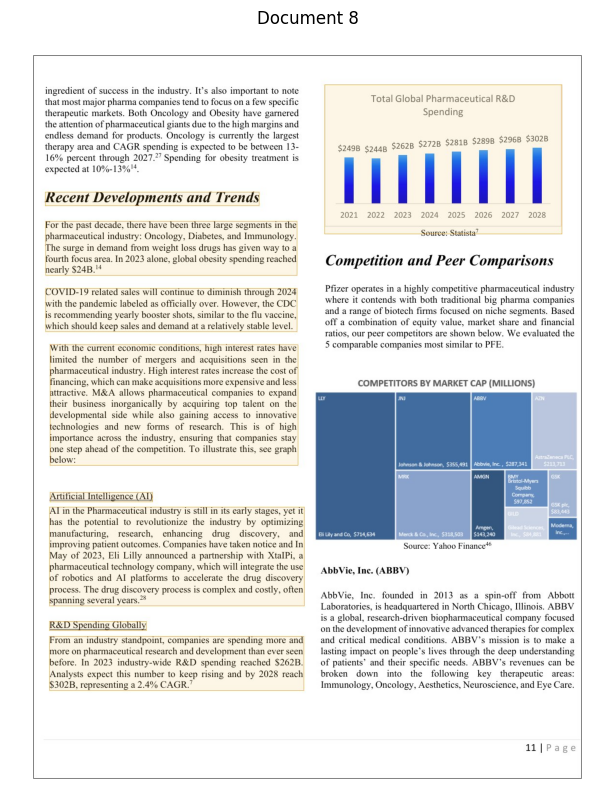


--- Processing Document 9 ---
Retrieval Info for Document 9:


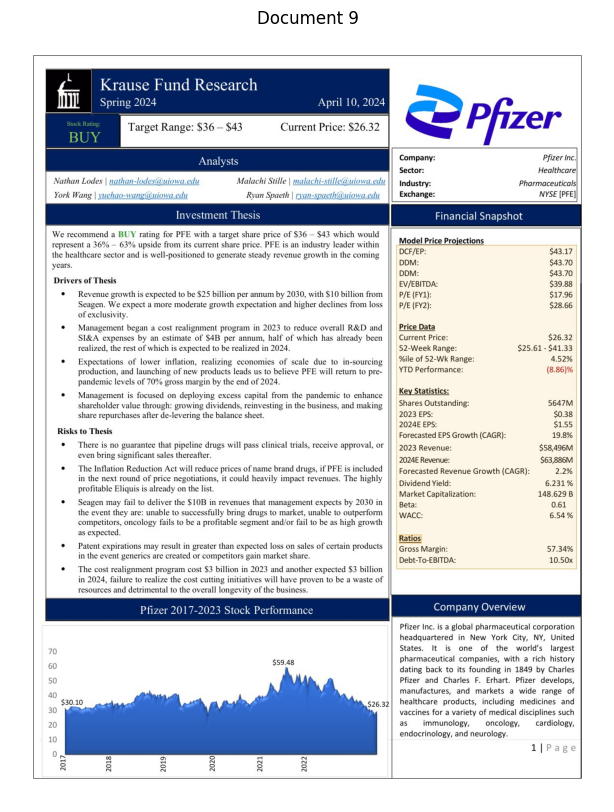


--- Processing Document 10 ---
Retrieval Info for Document 10:


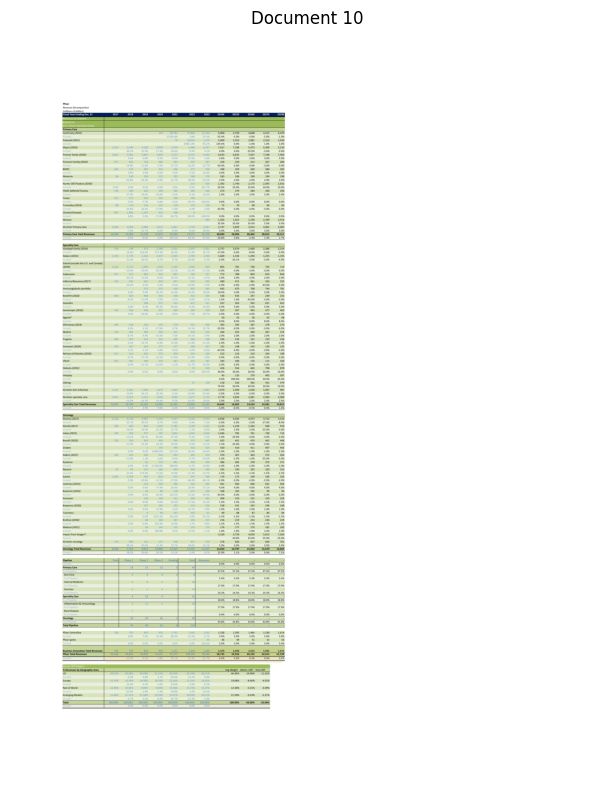


--- Processing Document 11 ---
Retrieval Info for Document 11:


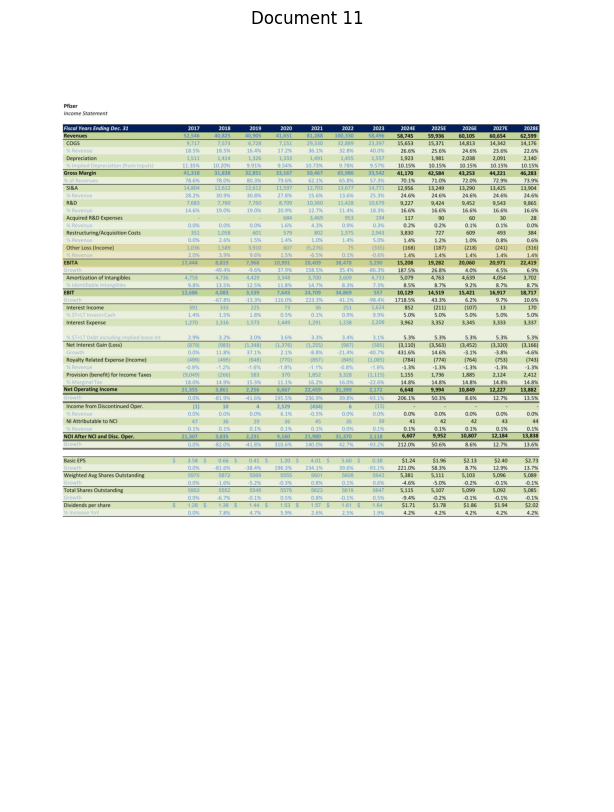


--- Processing Document 12 ---
Retrieval Info for Document 12:


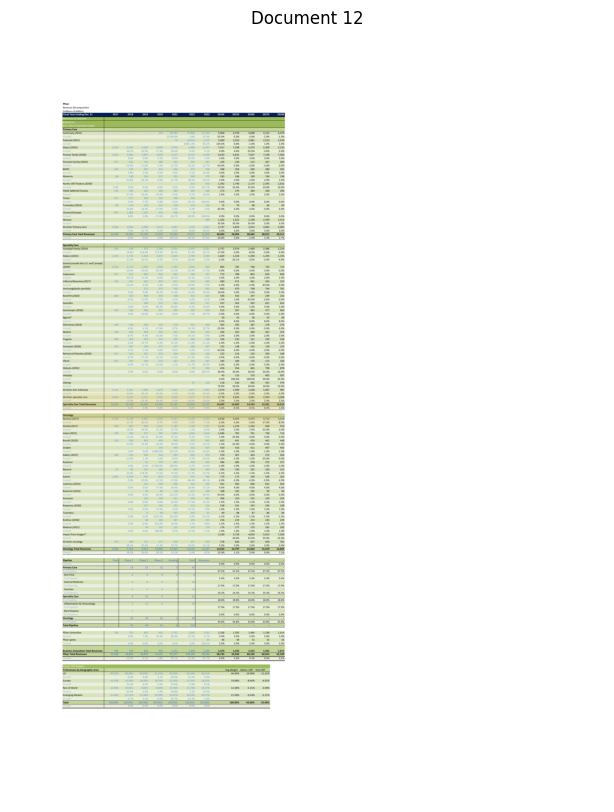


--- Processing Document 13 ---
Retrieval Info for Document 13:


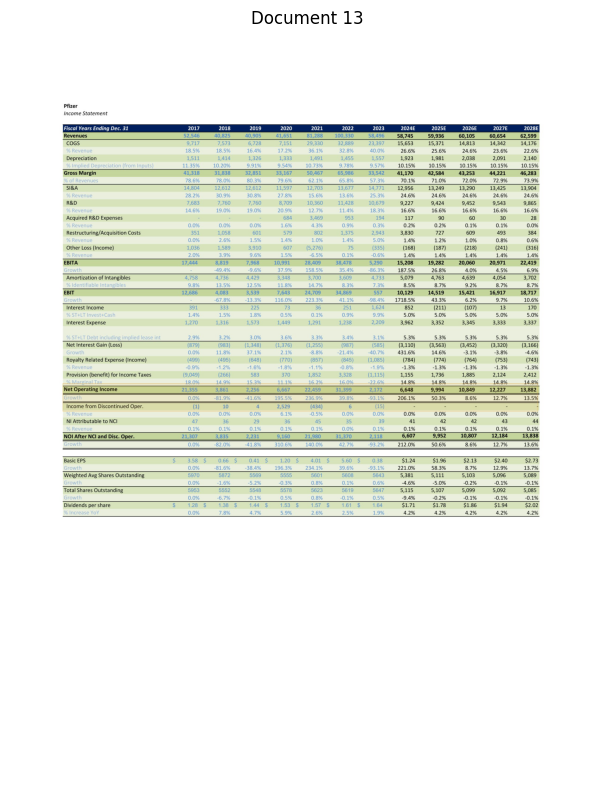


--- Processing Document 14 ---
Retrieval Info for Document 14:


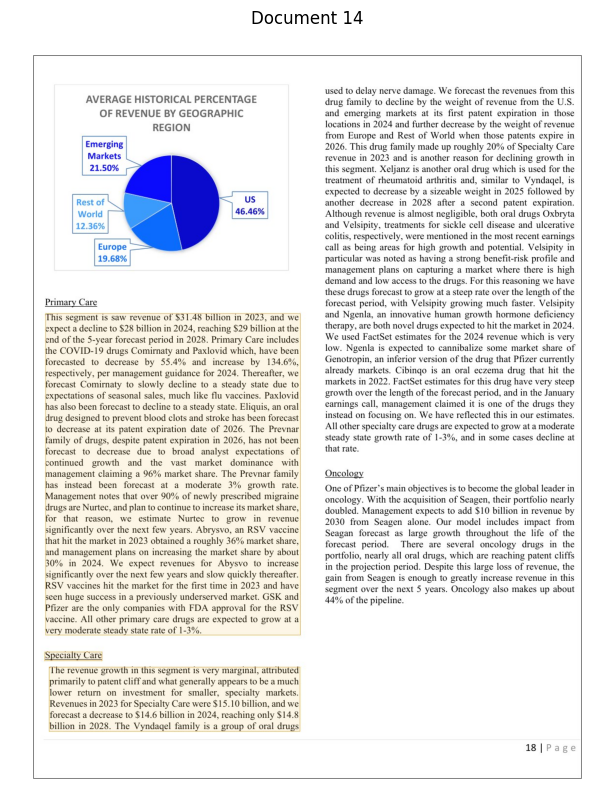


--- Processing Document 15 ---
Retrieval Info for Document 15:


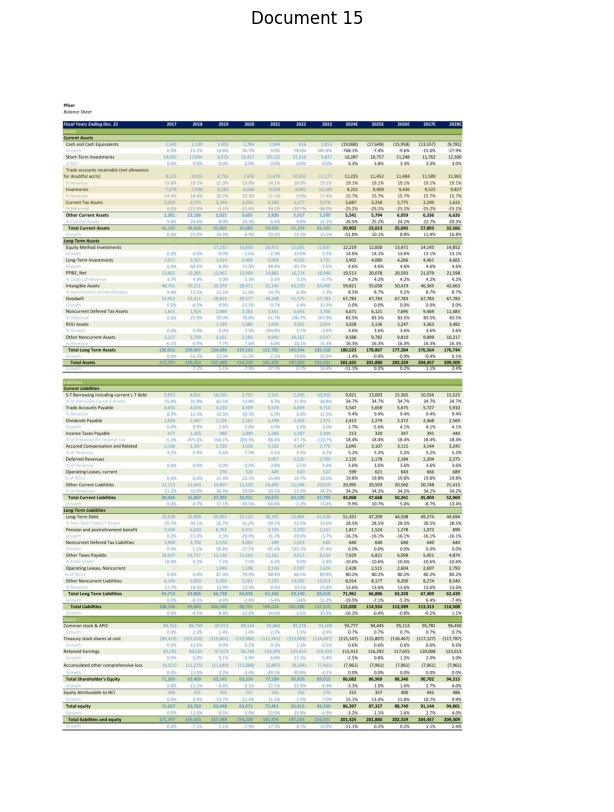


Total documents processed: 15


In [29]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(base64_string, title="Document"):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

    return img

# Retrieve and display all referenced documents
for i, retrieval_content in enumerate(query_result.retrieval_contents):
    print(f"\n--- Processing Document {i+1} ---")

    # Get retrieval info for this document
    ret_result = client.agents.query.retrieval_info(
        message_id=query_result.message_id,
        agent_id=agent_id,
        content_ids=[retrieval_content.content_id]
    )

    print(f"Retrieval Info for Document {i+1}:")

    # Display the document image
    if ret_result.content_metadatas and ret_result.content_metadatas[0].page_img:
        base64_string = ret_result.content_metadatas[0].page_img
        img = display_base64_image(base64_string, f"Document {i+1}")
    else:
        print(f"No image available for Document {i+1}")

print(f"\nTotal documents processed: {len(query_result.retrieval_contents)}")

## 5.1 LMUnit: Natural Language Unit Testing

 Evaluation, while not part of the core RAG pipeline, is a critical component to validating a RAG system before deploying to production. LMUnit is a language model optimized for evaluating natural language unit tests. LMUnit brings the rigor, familiarity, and accessibility of traditional software engineering unit testing to Large Language Model (LLM) evaluation.

LMUnit sets the state of the art for fine-grained evaluation, as measured by FLASK and BiGGen Bench, and performs on par with frontier models for coarse evaluation of long-form responses (per LFQA). The model also demonstrates exceptional alignment with human preferences, ranking in the top 5 of the RewardBench benchmark with 93.5% accuracy.

### Natural Language Unit Tests

A unit test is a specific, clear, testable statement or question in natural language about a desirable quality of an LLM's response. Just as traditional unit tests check individual functions in software, unit tests in this paradigm evaluate discrete qualities of individual model outputs – from basic accuracy and formatting to complex reasoning and domain-specific requirements.

### Types of Unit Tests

- **Global unit tests**: Applied to all queries in an evaluation set (e.g., "Does the response maintain a formal style?")
- **Targeted unit tests**: Focused assessment of query-level details (e.g., for "Describe Stephen Curry's legacy" → "Does the response mention that Stephen Curry is the greatest shooter in NBA history?")

For more information about LMUnit, you can read this [blog](https://contextual.ai/lmunit/?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook).

Let's start with a basic example to understand how LMUnit works. LMUnit takes three inputs: a query, a response, and a unit test, then produces a continuous score between 1 and 5.

In [30]:
query = "What was Seagen’s total revenue in 2022?"

response = """Seagen’s total revenue for 2022, as reported in their 10-K, was $1.96 billion.

This amount represents a 15.3% increase over 2021. The majority of revenue was driven by product sales for Adcetris and Padcev."""

unit_test = "Does the response avoid unnecessary information?"

# Evaluate with LMUnit
result = client.lmunit.create(
    query=query,
    response=response,
    unit_test=unit_test
)

print(f"Unit Test: {unit_test}")
print(f"Score: {result.score}/5")
print(f"\nAnalysis: The response includes extra details about growth rate and products,")
print(f"which may reduce the score for unnecessary information depending on context.")


Unit Test: Does the response avoid unnecessary information?
Score: 3.424/5

Analysis: The response includes extra details about growth rate and products,
which may reduce the score for unnecessary information depending on context.


Based on this score, you could adjust your system prompt to specifically exclude any information besides the exact response needed to address the query.

Let's define a comprehensive set of unit tests for evaluating quantitative reasoning responses:

In [33]:
# Define comprehensive unit tests for quantitative reasoning
unit_tests = [
    "Does the response accurately identify all material risks disclosed in financial statements, legal contracts, and regulatory filings?",
    "Are all financial and risk-related figures precisely traced back to their document sources and cited with page numbers?",
    "Is regulatory compliance, including pending investigations and antitrust approvals, analyzed and cited based on the merger documents?",
    "Does the answer evaluate management’s synergy and integration estimates using both historical benchmarks and cited post-merger evidence?",
    "Are deal terms—such as termination conditions, breakup fees, or change-of-control provisions—summarized with specific contract references?",
    "Does the system capture and cite legal liabilities, pending litigations, and compliance exposures called out in the filings?",
    "Are recommendations for go/no-go acquisition and negotiation topics supported by cross-document evidence?",
    "Is the generated risk matrix exhaustive, ranking major risks by both probability and impact, and does it justify each score using the source material?",
]


# Create category mapping for visualization
test_categories = {
    'Does the response accurately extract key financial, legal, and regulatory data from Pfizer and Seagen documents?': 'ACCURACY',
    'Does the agent distinguish between risk correlation and actual causation in evaluating litigation, regulatory, or financial exposures?': 'CAUSATION',
    'Are multi-document (10-K, merger agreement, industry report) cross-references and synthesis performed correctly in answers?': 'SYNTHESIS',
    'Are limitations, uncertainties, or missing disclosures in the data identified or flagged in the output?': 'LIMITATIONS',
    'Are all quantitative claims (ratios, debt levels, revenue, market share, risk scores) properly supported with specific evidence and source citations?': 'EVIDENCE',
    'Does the response avoid unnecessary or irrelevant information and focus on actionable due diligence findings?': 'RELEVANCE'
}


print("Unit Test Framework:")
print("=" * 50)
for i, test in enumerate(unit_tests, 1):
    category = next((v for k, v in test_categories.items() if k.lower() in test.lower()), 'OTHER')
    print(f"{i}. {category}: {test}")

Unit Test Framework:
1. OTHER: Does the response accurately identify all material risks disclosed in financial statements, legal contracts, and regulatory filings?
2. OTHER: Are all financial and risk-related figures precisely traced back to their document sources and cited with page numbers?
3. OTHER: Is regulatory compliance, including pending investigations and antitrust approvals, analyzed and cited based on the merger documents?
4. OTHER: Does the answer evaluate management’s synergy and integration estimates using both historical benchmarks and cited post-merger evidence?
5. OTHER: Are deal terms—such as termination conditions, breakup fees, or change-of-control provisions—summarized with specific contract references?
6. OTHER: Does the system capture and cite legal liabilities, pending litigations, and compliance exposures called out in the filings?
7. OTHER: Are recommendations for go/no-go acquisition and negotiation topics supported by cross-document evidence?
8. OTHER: Is th

We can also create sample prompt-response pairs for evaluation:

In [34]:
# Sample evaluation dataset
evaluation_data = [
    {
        "prompt": "What was Seagen’s total revenue reported in the 2022 10-K filing?",
        "response": "Seagen’s total revenue for 2022, as reported in their 10-K, was $1.96 billion, reflecting strong year-over-year growth driven by its oncology pipeline."
    },
    {
        "prompt": "What breakup fee is stipulated in the Pfizer–Seagen merger agreement?",
        "response": "The agreement specifies a termination (breakup) fee of $1.64 billion payable by Seagen to Pfizer if certain conditions are not met, as detailed in Section 8.3."
    },
    {
        "prompt": "How does Seagen’s market share in US oncology compare to top competitors according to recent industry analysis?",
        "response": "Seagen held an estimated 7% US oncology market share in targeted therapies for 2024, positioning it behind Roche/Genentech and Novartis as outlined in the industry report."
    },
    {
        "prompt": "Summarize the key regulatory risks highlighted for this acquisition.",
        "response": "Key regulatory risks include ongoing FTC antitrust review due to market concentration and FDA inspection delays for lead product BLA approval, both cited in recent filings."
    },
    {
        "prompt": "What synergy savings are projected by Pfizer management versus industry benchmarks for similar oncology M&A?",
        "response": "Pfizer projects $1.2 billion in annual synergies by 2027, which is modestly above the oncology M&A average according to McKinsey industry studies."
    }
]



eval_df = pd.DataFrame(evaluation_data)
print("Sample Evaluation Dataset:")
print(eval_df.to_string(index=False))

Sample Evaluation Dataset:
                                                                                                         prompt                                                                                                                                                                     response
                                              What was Seagen’s total revenue reported in the 2022 10-K filing?                      Seagen’s total revenue for 2022, as reported in their 10-K, was $1.96 billion, reflecting strong year-over-year growth driven by its oncology pipeline.
                                          What breakup fee is stipulated in the Pfizer–Seagen merger agreement?              The agreement specifies a termination (breakup) fee of $1.64 billion payable by Seagen to Pfizer if certain conditions are not met, as detailed in Section 8.3.
How does Seagen’s market share in US oncology compare to top competitors according to recent industry analysis?  Seage


Now let's run our unit tests across all evaluation examples:

In [35]:
def run_unit_tests_with_progress(
    df: pd.DataFrame,
    unit_tests: List[str]
) -> List[Dict]:
    """
    Run unit tests with progress tracking and error handling.
    """
    results = []

    for idx in tqdm(range(len(df)), desc="Processing responses"):
        row = df.iloc[idx]
        row_results = []

        for test in unit_tests:
            try:
                result = client.lmunit.create(
                    query=row['prompt'],
                    response=row['response'],
                    unit_test=test
                )

                row_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })

            except Exception as e:
                print(f"Error with prompt {idx}, test '{test}': {e}")
                row_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        results.append({
            'prompt': row['prompt'],
            'response': row['response'],
            'test_results': row_results
        })

    return results

# Run the evaluation
print("Running comprehensive unit test evaluation...")
results = run_unit_tests_with_progress(eval_df, unit_tests)

# Display detailed results
for i, result in enumerate(results):
    print(f"\n{'='*60}")
    print(f"EVALUATION {i+1}")
    print(f"{'='*60}")
    print(f"Prompt: {result['prompt']}")
    print(f"Response: {result['response'][:100]}...")
    print("\nUnit Test Scores:")

    for test_result in result['test_results']:
        if 'score' in test_result and test_result['score'] is not None:
            category = next((v for k, v in test_categories.items() if k.lower() in test_result['test'].lower()), 'OTHER')
            print(f"  {category}: {test_result['score']:.2f}/5")
        else:
            print(f"  Error: {test_result.get('error', 'Unknown error')}")

Running comprehensive unit test evaluation...


Processing responses:   0%|          | 0/5 [00:00<?, ?it/s]

Processing responses: 100%|██████████| 5/5 [01:34<00:00, 18.80s/it]


EVALUATION 1
Prompt: What was Seagen’s total revenue reported in the 2022 10-K filing?
Response: Seagen’s total revenue for 2022, as reported in their 10-K, was $1.96 billion, reflecting strong yea...

Unit Test Scores:
  OTHER: 1.47/5
  OTHER: 1.65/5
  OTHER: 1.35/5
  OTHER: 1.16/5
  OTHER: 1.13/5
  OTHER: 1.23/5
  OTHER: 1.87/5
  OTHER: 1.17/5

EVALUATION 2
Prompt: What breakup fee is stipulated in the Pfizer–Seagen merger agreement?
Response: The agreement specifies a termination (breakup) fee of $1.64 billion payable by Seagen to Pfizer if ...

Unit Test Scores:
  OTHER: 3.42/5
  OTHER: 2.35/5
  OTHER: 2.17/5
  OTHER: 1.10/5
  OTHER: 4.66/5
  OTHER: 4.14/5
  OTHER: 3.98/5
  OTHER: 1.22/5

EVALUATION 3
Prompt: How does Seagen’s market share in US oncology compare to top competitors according to recent industry analysis?
Response: Seagen held an estimated 7% US oncology market share in targeted therapies for 2024, positioning it ...

Unit Test Scores:
  OTHER: 1.44/5
  OTHER: 1.59/5


Let's create polar plots to visualize the unit test results:

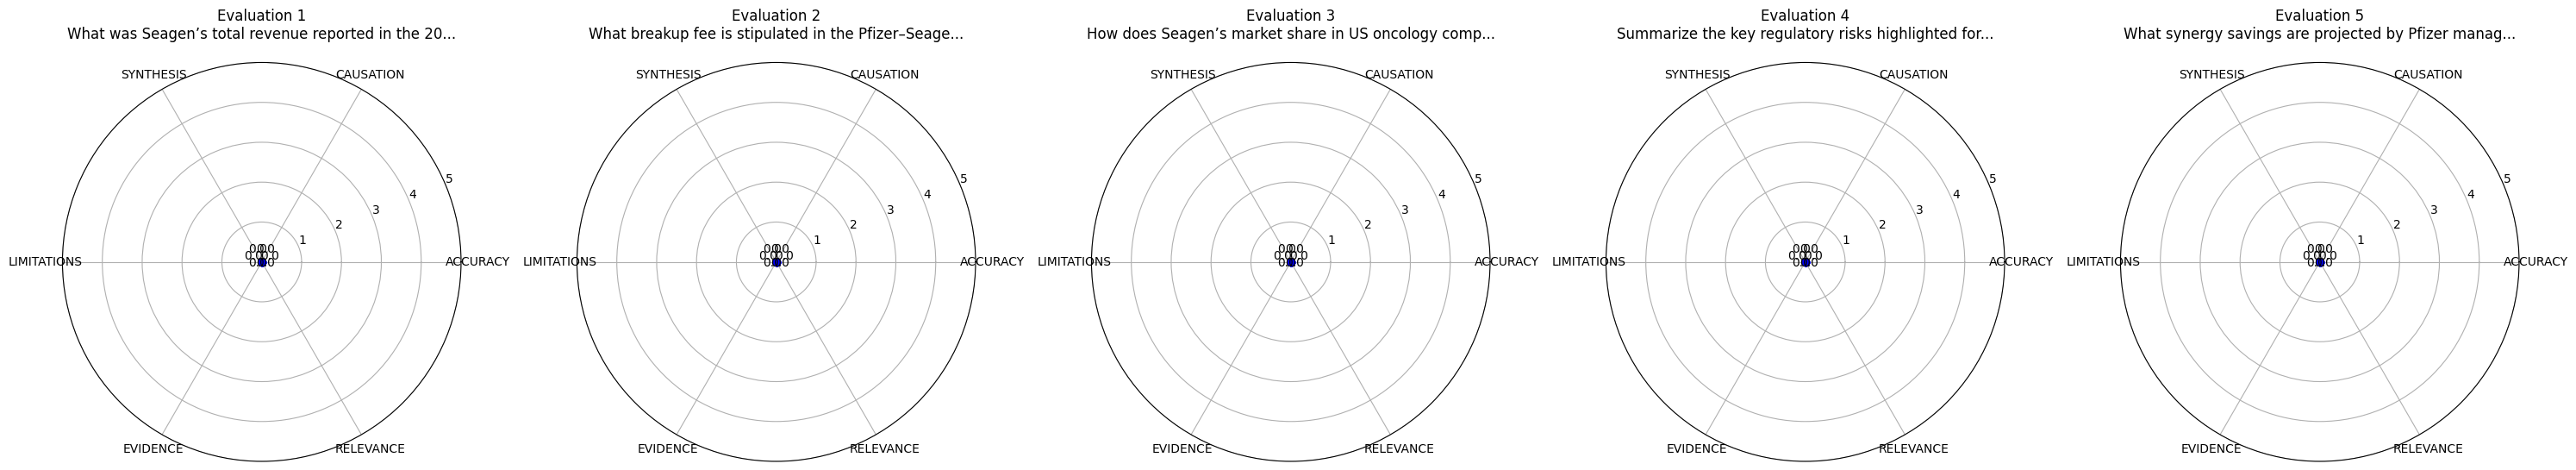

In [36]:
def map_test_to_category(test_question: str) -> str:
    """Map the full test question to its category."""
    for key, value in test_categories.items():
        if key.lower() in test_question.lower():
            return value
    return None

def create_unit_test_plots(results: List[Dict], test_indices: Optional[List[int]] = None):
    """
    Create polar plot(s) for unit test results.
    """
    if test_indices is None:
        test_indices = list(range(len(results)))
    elif isinstance(test_indices, int):
        test_indices = [test_indices]

    categories = ['ACCURACY', 'CAUSATION', 'SYNTHESIS', 'LIMITATIONS', 'EVIDENCE', 'RELEVANCE']
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    num_plots = len(test_indices)
    fig = plt.figure(figsize=(6 * num_plots, 6))

    for plot_idx, result_idx in enumerate(test_indices):
        result = results[result_idx]
        ax = plt.subplot(1, num_plots, plot_idx + 1, projection='polar')

        scores = []
        for category in categories:
            score = None
            for test_result in result['test_results']:
                mapped_category = map_test_to_category(test_result['test'])
                if mapped_category == category:
                    score = test_result['score']
                    break
            scores.append(score if score is not None else 0)

        scores = np.concatenate((scores, [scores[0]]))

        ax.plot(angles, scores, 'o-', linewidth=2, color='blue')
        ax.fill(angles, scores, alpha=0.25, color='blue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 5)
        ax.grid(True)

        for angle, score, category in zip(angles[:-1], scores[:-1], categories):
            ax.text(angle, score + 0.2, f'{score:.1f}', ha='center', va='bottom')

        prompt = result['prompt'][:50] + "..." if len(result['prompt']) > 50 else result['prompt']
        ax.set_title(f"Evaluation {result_idx + 1}\n{prompt}", pad=20)

    plt.tight_layout()
    return fig

# Create visualizations
if len(results) > 0:
    fig = create_unit_test_plots(results)
    plt.show()
else:
    print("No results to visualize")


Let's analyze the overall performance across all categories:

In [37]:
# Create aggregate analysis
all_scores = []
for result in results:
    for test_result in result['test_results']:
        if 'score' in test_result and test_result['score'] is not None:
            category = map_test_to_category(test_result['test'])
            all_scores.append({
                'category': category,
                'score': test_result['score'],
                'test': test_result['test']
            })

scores_df = pd.DataFrame(all_scores)

if not scores_df.empty:
    # Calculate average scores by category
    avg_scores = scores_df.groupby('category')['score'].agg(['mean', 'std', 'count']).round(2)

    print("\nAggregate Performance by Category:")
    print("=" * 50)
    print(avg_scores)

    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"Mean Score: {scores_df['score'].mean():.2f}/5")
    print(f"Standard Deviation: {scores_df['score'].std():.2f}")
    print(f"Total Evaluations: {len(scores_df)}")
else:
    print("No valid scores to analyze")


Aggregate Performance by Category:
Empty DataFrame
Columns: [mean, std, count]
Index: []

Overall Statistics:
Mean Score: 1.94/5
Standard Deviation: 1.07
Total Evaluations: 40


Interestingly, several of our unit tests are tricky to all score high on: if a response ranks high on CAUSATION (Does the agent properly distinguish between correlation and causation) and LIMITATIONS (Are potential limitations or uncertainties in the data clearly acknowledged?), it may be difficul to also score high on RELEVANCE (Does the response avoid unnecessary information?)

You can try all of the analyses above with your own system by generating the responses, and testing those query-response pairs.

For more example code for Contextual AI's LMUnit, see our [LMUnit examples notebook](https://github.com/ContextualAI/examples/tree/main/03-standalone-api/01-lmunit?utm_campaign=rag-techniques&utm_source=diamantai&utm_medium=github&utm_content=notebook)

![](https://europe-west1-rag-techniques-views-tracker.cloudfunctions.net/rag-techniques-tracker?notebook=all-rag-techniques--agentic-rag)
